In [13]:
import torch
import torchtext
from torch.utils.data import DataLoader
from torchtext.datasets import YelpReviewFull, AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
from torch.nn import Embedding, Linear, RNN
import os
import itertools
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
# NB: downloads about 160M
train_data = AG_NEWS(root=os.getcwd(), split='train')
val_data = AG_NEWS(root=os.getcwd(), split='test')

# convenience function to shorten news clips so don't have too much recurrence 
# (the longer the sequences, the more training time needed)

def chop(lst, maxlen=50):
    chopped = lst if len(lst) < maxlen else lst[:maxlen]
    return chopped

In [3]:
# This is an iterable type data set, so can't index it
# to get a sample element, use the iterator interface

#NB: newlines are encoded as '\', maybe have better performance (and less UNK tokens) if substitute with whitespace.

samples = itertools.islice(train_data, 3)
for (label, review) in samples:
    print(f"TEXT:\t{review}\nLABEL:\t{label}\n")

# reload the train data set, because consumed part of it in this example
train_data = AG_NEWS(root=os.getcwd(), split='train')

TEXT:	Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
LABEL:	3

TEXT:	Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
LABEL:	3

TEXT:	Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
LABEL:	3



In [4]:
# Use Spacy tokenizer (better than torchtext's built-in)
# assumes spacy package is installed (pip install spacy)
# then install language model (~450M) with
# python -m spacy download en_core_web_trf (or _sm instead of _trf for smaller)
en_tokenizer=get_tokenizer('spacy', language='en_core_web_trf')

In [5]:
# example of a tokenized review
print(f"RAW:\t{review}\nTOKENIZED:\t{en_tokenizer(review)}")

RAW:	Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
TOKENIZED:	['Oil', 'and', 'Economy', 'Cloud', 'Stocks', "'", 'Outlook', '(', 'Reuters', ')', 'Reuters', '-', 'Soaring', 'crude', 'prices', 'plus', 'worries\\about', 'the', 'economy', 'and', 'the', 'outlook', 'for', 'earnings', 'are', 'expected', 'to\\hang', 'over', 'the', 'stock', 'market', 'next', 'week', 'during', 'the', 'depth', 'of', 'the\\summer', 'doldrums', '.']


In [6]:
# NB: this takes time to run
# create the vocabulary for this dataset by tokenizing all the training examples (not validation, because in reality
# we wouldn't know what data the model will be used on)
# add the special tokens UNKNOWN, PAD, BEGIN-SENTENCE, END-SENTENCE
# default out of vocabulary tokens to be replaced with UNKNOWN

def yield_tokens(dloader):
    for (label, review) in dloader:
        yield en_tokenizer(review)
        
vocab = build_vocab_from_iterator(yield_tokens(iter(train_data)), min_freq = 30, specials=["<UNK>", "<PAD>", "<BOS>", "<EOS>"])
vocab.set_default_index(vocab["<UNK>"])

# reload because consumed
train_data = AG_NEWS(root=os.getcwd(), split='train')

In [7]:
# use vocab to replace the tokens with indices into the vocabulary
review = next(iter(train_data))[1]
tokenized = en_tokenizer(review)
indices = vocab(tokenized)

print(f"RAW:\t{review}\nTOKENIZED:\t{tokenized}\nINDICES:\t{indices}")

# reload because consumed
train_data = AG_NEWS(root=os.getcwd(), split='train')

RAW:	Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
TOKENIZED:	['Wall', 'St.', 'Bears', 'Claw', 'Back', 'Into', 'the', 'Black', '(', 'Reuters', ')', 'Reuters', '-', 'Short', '-', 'sellers', ',', 'Wall', 'Street', "'s", 'dwindling\\band', 'of', 'ultra', '-', 'cynics', ',', 'are', 'seeing', 'green', 'again', '.']
INDICES:	[448, 575, 2060, 0, 1199, 1721, 4, 1383, 17, 33, 18, 33, 8, 4036, 8, 10270, 5, 448, 423, 25, 0, 10, 8380, 8, 0, 5, 48, 4739, 3037, 375, 6]


In [8]:
# create DataLoaders for the tokenized datasets
# add BOS and EOS tokens at start and end of reviews
# pad the reviews in each minibatch as necessary so they all have the same length, to allow calling the RNN using minibatching

def transform(review):
    return torch.tensor([vocab[token] for token in chop(en_tokenizer(review))])

def generate_batch(data_batch):
    labels, reviews = [], []
    for (label, review) in data_batch:
        labels.append(label-1)
        reviews.append(torch.cat([torch.tensor([vocab["<BOS>"]]), transform(review), torch.tensor([vocab["<EOS>"]])]))
    reviews = pad_sequence(reviews, padding_value = vocab["<PAD>"] )
    return reviews.to(device), torch.tensor(labels, dtype=torch.int64).to(device)

batchsize = 256
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=False, collate_fn=generate_batch)
val_loader = DataLoader(val_data, batch_size=batchsize, shuffle=False, collate_fn=generate_batch)

In [9]:
# Classifier network using RNN:
# an embedding layer that converts the token indices to vectors
# an RNN that takes the input vector sequence and returns the corresponding sequence of hidden states
# extract the last hidden state and use a linear layer to convert to logits

class RNNclassifier(nn.Module):

    def __init__(self, vocab, numclasses, embedding_dim, hidden_size, num_layers=1, nonlinearity="tanh"):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.vocab = vocab
        self.embeddings = Embedding(len(vocab), embedding_dim)
        self.RNN = RNN(embedding_dim, hidden_size, num_layers, nonlinearity=nonlinearity)
        self.logits = Linear(hidden_size, numclasses)
        
    def forward(self, x):
        # NB: inputs have shape [len_of_sequence, batchsize]
        # embedding layer converts to [len_of_sequence, batchsize, embedding_dim]
        x = self.embeddings(x)
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
        hiddenStates, _ = self.RNN(x, h0)
        out = hiddenStates[-1, :, :] # use the last hidden state as the inputs to the logit layer
        return self.logits(out)

In [10]:
# Standard training infrastructure
embedding_dim = 100
hidden_size = 300
lr = 0.001
epochs = 30

model = RNNclassifier(vocab, 4, embedding_dim, hidden_size, nonlinearity="relu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, criterion, optimizer, trainloader, clip=1, verbose=True, interval=100):
    model.train()
    #numbatches = len(trainloader)
    for (idx, (inputs, targets)) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        #clip_grad_norm_(model.parameters(), clip) # gradient clipping can help
        optimizer.step()
        if (idx + 1) % interval == 0:
            if verbose: print(f"\t Training loss on minibatch {idx+1}/?: {loss.item()/len(targets):>5f}")

def validate(model, criterion, valloader):
    model.eval()
    test_loss = 0
    correct = 0
    numsamples = 0 # len(valloader.dataset)
    with torch.no_grad():
        for (idx, (inputs, targets)) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            correct += (outputs.argmax(1) == targets).type(torch.float).sum().item()
            numsamples += len(targets)
    loss = test_loss/numsamples
    accuracy = 100*correct/numsamples
    print(f"\tValidation loss/accuracy: {loss:>5f}/{accuracy:>5f}")
    return loss, accuracy

In [11]:
# Really should save the best performing model as we go along
losses = []
accuracies = []
verbose = True

print("Training AG_NEWS RNN classification model")
print("---------------------------------------------")
for e in range(epochs):
    print(f"Epoch {e+1}/{epochs}:")
    train_epoch(model, criterion, optimizer, train_loader, verbose=verbose, interval=100)
    loss, accuracy = validate(model, criterion, val_loader)
    losses.append(loss)
    accuracies.append(accuracy)
    # reload because consumed
    train_data = AG_NEWS(root=os.getcwd(), split='train')
    train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=False, collate_fn=generate_batch)
    val_data = AG_NEWS(root=os.getcwd(), split='test')
    val_loader = DataLoader(val_data, batch_size=batchsize, shuffle=False, collate_fn=generate_batch)

Training yelp review RNN classification model
---------------------------------------------
Epoch 1/30:
	 Training loss on minibatch 100/?: 0.005445
	 Training loss on minibatch 200/?: 0.005402
	 Training loss on minibatch 300/?: 0.005336
	 Training loss on minibatch 400/?: 0.005363
	Validation loss/accuracy: 0.005488/25.736842
Epoch 2/30:
	 Training loss on minibatch 100/?: 0.005416
	 Training loss on minibatch 200/?: 0.005436
	 Training loss on minibatch 300/?: 0.005376
	 Training loss on minibatch 400/?: 0.005389
	Validation loss/accuracy: 0.005431/28.223684
Epoch 3/30:
	 Training loss on minibatch 100/?: 0.004349
	 Training loss on minibatch 200/?: 0.003535
	 Training loss on minibatch 300/?: 0.002998
	 Training loss on minibatch 400/?: 0.002693
	Validation loss/accuracy: 0.002848/71.697368
Epoch 4/30:
	 Training loss on minibatch 100/?: 0.002040
	 Training loss on minibatch 200/?: 0.002371
	 Training loss on minibatch 300/?: 0.002188
	 Training loss on minibatch 400/?: 0.001926
	V

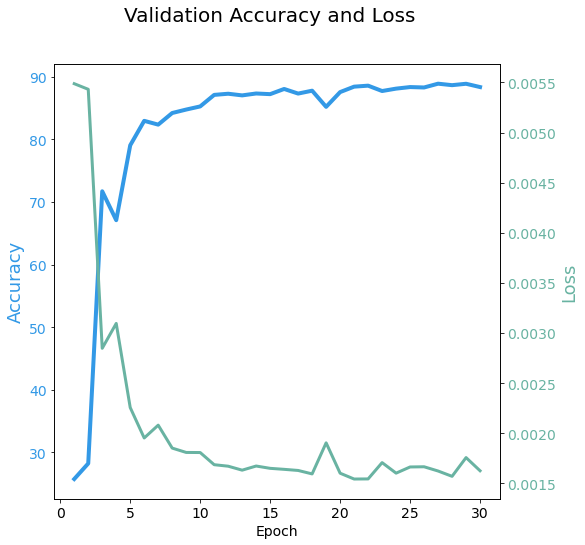

In [32]:
COLOR_ACCURACY = "#3399e6"
COLOR_LOSS = "#69b3a2"
epochs = [i+1 for i in range(len(accuracies))]
          
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.plot(epochs, accuracies, color=COLOR_ACCURACY, lw=4)
ax2.plot(epochs, losses, color=COLOR_LOSS, lw=3)

ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Accuracy", color=COLOR_ACCURACY, fontsize=18)
ax1.tick_params(axis="y", labelcolor=COLOR_ACCURACY)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)

ax2.set_ylabel("Loss", color=COLOR_LOSS, fontsize=18)
ax2.tick_params(axis="y", labelcolor=COLOR_LOSS)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)

fig.suptitle("Validation Accuracy and Loss", fontsize=20);